In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
# load_libs()

# Result Summary

## Bivar Result Summary

### R square'

In [2]:
figsize=(3.8,3)
handle_length=1.8

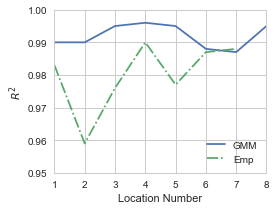

In [6]:
# Plot result
x=arange(1,9)
gmm_rsquare = [0.990,0.990,0.995,0.996,0.995,0.988,0.987,0.995,]
emp_rsquare = [0.983,0.959,0.976,0.990,0.977,0.987,0.988,]
plot(x, gmm_rsquare, label='GMM')
plot(x[:-1], emp_rsquare, '-.', label='Emp')
plt.axis([1,8,0.95,1])
plt_configure(xlabel='Location Number', ylabel="${R^2}$", legend={'handlelength': handle_length}, figsize=figsize)

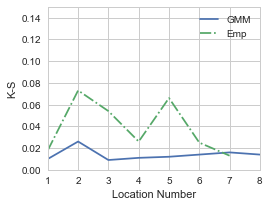

In [11]:
x=arange(1,9)
gmm_gof_result = [0.01,0.026,0.009,0.011,0.012,0.014,0.016,0.014,]
emp_gof_result = [0.018,0.073,0.054,0.026,0.066,0.025,0.013,]
plot(x, gmm_gof_result, label='GMM')
plot(x[:-1], emp_gof_result, '-.', label='Emp')
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.axis([1,8,0,ylim])
plt_configure(xlabel='Location Number', ylabel="K-S", legend={'handlelength': handle_length}, figsize=figsize)

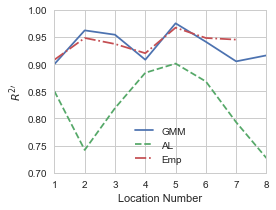

In [27]:
# Plot result
x=arange(1,9)
gmm_rsquare = [0.90,0.962,0.954,0.908,0.975,0.941,0.905,0.916,]
al_rsquare=[0.85,0.742,0.819,0.884,0.901,0.868,0.793,0.727]
emp_rsquare = [0.908,0.948,0.937,0.920,0.967,0.948,0.945,]
plot(x, gmm_rsquare, label='GMM')
plot(x, al_rsquare, '--', label='AL')
plot(x[:-1], emp_rsquare, '-.', label='Emp')
plt.axis([1,8,0.7,1])
plt_configure(xlabel='Location Number', ylabel="${R^2}'$", legend={'handlelength': handle_length}, figsize=figsize)

### Sectoral Comparison

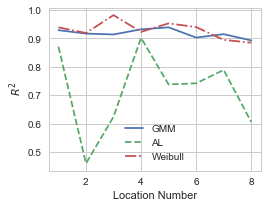

In [4]:
gmm_rsquare = [0.929,0.917,0.914,0.932,0.939,0.903,0.915,0.893]
al_rsquare = [0.871,0.460,0.624,0.902,0.738,0.742,0.789,0.606,]
weibull_rsquare = [0.939,0.919,0.982,0.923,0.953,0.940,0.895,0.885,]

plot(x, gmm_rsquare, label='GMM')
plot(x, al_rsquare, '--', label='AL')
plot(x, weibull_rsquare , '-.', label='Weibull')
# ylim = min(plt.gca().get_ylim()[0], .7)
# plt.axis([1,8,ylim,1])
plt_configure(xlabel='Location Number', ylabel="$\ R^2$", legend={'handlelength': handle_length}, figsize=figsize)

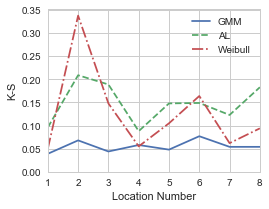

In [5]:
gmm_ks =[0.039,0.068,0.044,0.058,0.048,0.077,0.054,0.054,]
weibull_ks=[0.05,0.338,0.148,0.055,0.105,0.164,0.062,0.094,]
al_ks=[0.096,0.209,0.189,0.088,0.148,0.149,0.123,0.183,]
plot(x, gmm_ks, label='GMM')
plot(x, al_ks, '--', label='AL')
plot(x, weibull_ks , '-.', label='Weibull')
ylim = max(plt.gca().get_ylim()[1],0.25)
plt.axis([1,8,0,ylim])
plt_configure(xlabel='Location Number', ylabel="K-S", legend={'handlelength': handle_length}, figsize=figsize)

## Univar Result Summary

### Speed

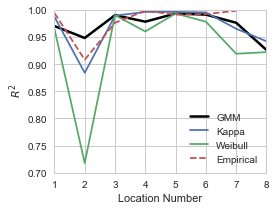

In [6]:
gmm_rsquare = [0.970,0.948,0.990,0.978,0.993,0.991,0.976,0.926,]
weibull_rsquare = [0.965,0.718,0.990,0.960,0.993,0.978,0.919,0.922,]
kappa_rsquare = [0.987,0.884,0.989,0.996,0.996,0.995,0.965,0.942,]
empirical_rsquare=[0.994,0.908,0.976,0.998,0.991,0.992,0.998,]

plot(x, gmm_rsquare, label='GMM', color='black', linewidth=2.5)
plot(x, kappa_rsquare, label='Kappa',)
plot(x, weibull_rsquare , label='Weibull')
plot(x[:-1], empirical_rsquare , '--', label='Empirical')

ylim = min(plt.gca().get_ylim()[0], .7)
plt.axis([1,8,ylim,1])
plt_configure(xlabel='Location Number', ylabel="$\ R^2$", legend={'handlelength': handle_length}, figsize=figsize)

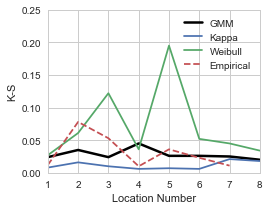

In [7]:
gmm_ks =[0.024,0.035,0.024,0.045,0.026,0.026,0.025,0.020]
weibull_ks=[0.027,0.061,0.122,0.036,0.195,0.052,0.045,0.034]
kappa_ks=[0.008,0.016,0.010,0.006,0.007,0.006,0.021,0.018]
empirical_ks = [0.012,0.078,0.053,0.010,0.036,0.023,0.011,]
plot(x, gmm_ks, label='GMM', color='black', linewidth=2.5)
plot(x, kappa_ks, label='Kappa')
plot(x, weibull_ks , label='Weibull')
plot(x[:-1], empirical_ks, '--', label='Empirical')

ylim = max(plt.gca().get_ylim()[1],0.25)
plt.axis([1,8,0,ylim])
plt_configure(xlabel='Location Number', ylabel="K-S", legend={'handlelength': handle_length}, figsize=figsize)

### Direction

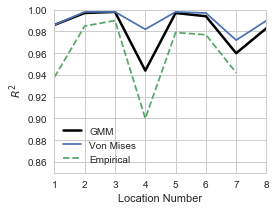

In [10]:
x=arange(1,9)
gmm_rsquare = [0.986,0.997,0.998,0.944,0.997,0.994,0.960,0.983]
vonmises_rsquare = [0.986,0.998,0.998,0.982,0.998,0.997,0.972,0.990]
empirical_rsquare = [0.938,0.985,0.990,0.90,0.979,0.977,0.942,]
plot(x, gmm_rsquare, label='GMM', color='black', linewidth=2.5)
plot(x, vonmises_rsquare, label='Von Mises')
plot(x[:-1], empirical_rsquare, '--', label='Empirical')
ylim = min(plt.gca().get_ylim()[0], .85)
plt.axis([1,8,ylim,1])
plt_configure(xlabel='Location Number', ylabel="$\ R^2$",  legend={'handlelength': handle_length}, figsize=figsize)

In [9]:
sss

NameError: name 'sss' is not defined

In [ ]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20

%%time
empirical_densities=Parallel(n_jobs=-1)(delayed(empirical_direction)(df, angle, rebinned_angle, bin_width=BIN_WIDTH) 
                                        for angle in arange(0, 360, rebinned_angle))  

gmm_densities=Parallel(n_jobs=-1)(delayed(gmm_direction)(gmm, df, angle, rebinned_angle, bin_width=BIN_WIDTH) 
                                        for angle in arange(0, 360, rebinned_angle))  

temp_collect = [{**empirical_density, **gmm_density} for empirical_density, gmm_density in zip(empirical_densities, gmm_densities)]

In [ ]:
bin_width=BIN_WIDTH
original_incre = 10
start, end = -original_incre/2 + rebinned_angle/2, 360
max_count = max_count_for_angles(df, start, end, rebinned_angle)
max_speed = df.speed.max()
plot_range = [0, max_speed, 0, max_count*1.05]

In [ ]:
for d in temp_collect:
    x = d['x']
    R_square_gmm = sector_r_square(d['density']*bin_width, d['density_expected'])
    print(R_square_gmm)
    
#     5. Make Plots
    fig = plt.figure(figsize=(10,1.9))
    # 5.1. Frequency Comparison
    ax1 = fig.add_subplot(1,3,1)        
    plt.bar(d_['bins'][:-1]+bin_width/2, d_['density']*len(df['dir']), width=bin_width, alpha=0.5, label='Data')
    plot(x, d_['y_gmm']*d_['data_size']*bin_width,'-', color='black', label='GMM')
    plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
    plt.axis(plot_range)

    # 5.2. CDF Comaprison
    ax2 = fig.add_subplot(1,3,2)
    plot(x, d_['y_ecdf'],'o', alpha=0.8, label='Data')
    plot(x, d_['y_cdf_gmm'],'-', color='black',label='GMM')
    plot(x, d_['y_cdf_weibull'],'--', color='black',label='Weibull')
    plt.gca().set_xlim(right = max_speed)
    plt_configure(xlabel = "V", ylabel='P', legend=True)

In [ ]:
ssss

In [ ]:
### Examning Data limit
df = df_all_years['2011':'2015']
# Bivar Diff
for resample_num in [1000, 10000, 100000, 1000000]:
    df_resample = df.sample(n=resample_num, replace=True)
    print(kde_gofs(df_resample,  kde_result, config))

In [ ]:
# Univar Diff
x = arange(0, df.speed.max() + 1)
_, _, density, y_ecdf, density_dir = empirical_marginal_distribution(df, x)
for resample_num in [1000, 10000, 100000, 1000000]:
    df_resample = df.sample(n=resample_num, replace=True)
    print(univar_gof(df_resample, density, y_ecdf, x, density_dir))

## 6.5 Insufficient-fit Sector Investigation

### (1) Data Variability, by Bootstrap (Resampling)

In [ ]:
angle =  max_diff_angle = diff_df.ix[diff_df['max_cdf_diff_gmm'].idxmax()]['direction']
incre = rebinned_angle

FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

### (2) Time Variability

In [ ]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))

ax2.plot(x, y_cdf_gmm,'-', color='black', label = 'GMM')
ax2.plot(x, y_cdf_weibull,'--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(2001, 2015, 5):
    end_time = start_time + 4 
    df_other_years = df_all_years[str(start_time):str(end_time)]
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = start_time)
        
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=start_time, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = start_time*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if start_time == 2011 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if start_time == 2011 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel = "V", ylabel='P', legend={'loc':'best'})

ax1.set_zlim(bottom = 0)
align_figures()

### (3) Adjacent Sector Variability

In [ ]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('direction == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['datasize'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

In [ ]:
locations = [[48,-98],[8,-67], [-52,-75],[65, -17],[18,32],[20,120],[-37,142],[36, -2]]
# locations = [[47,-123],[8,-67], [-52,-75],[65, -17],[49,9],[18,32],[24,121],[-37,142]]

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import string

plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

for position, num in zip(locations, arange(1,9)):
    print(position)
    plt.plot(position[1], position[0], marker='o', markersize=20, color='white')
    plt.text(position[1], position[0], num, verticalalignment='center', horizontalalignment='center')
    
plt_configure(xlabel='Longtitude (degree)', ylabel='Latitude (degree)')

In [ ]:
fig = plt.figure(figsize=(4.2,2.4))
ax1 = fig.add_subplot(1,2,1) 
plot_2d_prob_density(X, Y, kde_Z, ax=ax1,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax1.grid(False)
ax2 = fig.add_subplot(1,2,2) 
plot_2d_prob_density(X, Y, pdf_Z, ax=ax2,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax2.grid(False)
ax2.get_yaxis().set_visible(False)

# Empirical True R square

In [ ]:
%%time
true_R_square_mean_set=[]
for year_length in [5,10]:
    start_year, end_year = df_all_years.index.year[0], 2015-year_length+1
    df_standard = df_all_years[str(2015-year_length+1):str(2015)]
    true_R_square_set = []
    for sub_start_year in arange(start_year, end_year+1):
        sub_end_year = sub_start_year+year_length-1
        df_previous =  df_all_years[str(sub_start_year):str(sub_end_year)]
        density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(None, df_standard, angle, incre, True, df_previous) 
                                            for angle in arange(0, 360, incre))  
        true_R_square_set.append(true_R_square(density_collection))
    true_R_square_set=pd.DataFrame(true_R_square_set, index=arange(start_year, end_year+1))
    year_lim = end_year-year_length-5, end_year-year_length
    true_R_square_mean = true_R_square_set.query('index >= @year_lim[0] & index <= @year_lim[1]').mean()
    true_R_square_mean['year_lim']=year_lim
    true_R_square_mean_set.append(true_R_square_mean)
    plot(true_R_square_set, label=year_length)
plt_configure(legend=True)
display(pd.DataFrame(true_R_square_mean_set).set_index('year_lim'))